# Malarial cell detection using CNN


In [ ]:
import numpy as np

# Make sure to pip install tensorflow
# and pip install Keras

# Set the `numpy` pseudo-random generator at a fixed value
# This helps with repeatable results everytime you run the code.
np.random.seed(1000)

import matplotlib.pyplot as plt
import matplotlib.backends
import os
import cv2
from PIL import Image # pillow for resizing
import keras
import glob

os.environ['KERAS_BACKEND'] = 'tensorflow'  # Added to set the backend as Tensorflow

# Iterate through all images in Parasitized folder, resize to 64 x 64
# Then save as numpy array with name 'dataset'
# Set the label to this as 0

SIZE = 64 # size of the image
dataset = []  # Many ways to handle data, you can use pandas. Here, we are using a list format.
label = []  # Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

parasitized_images_path_all = "C:\\Users\\golub\\PycharmProjects\\pythonProject\\images\\cell_images\\Parasitized\\*"
parasitized_images_path = "C:\\Users\\golub\\PycharmProjects\\pythonProject\\images\\cell_images\\Parasitized"
parasitized_images_list = os.listdir(parasitized_images_path)

for file in glob.glob(parasitized_images_path_all): # reads all the files in the folder path
    image = cv2.imread(file)
    if type(image) == np.ndarray:
    #image = Image.fromarray(image, 'RGB') transform to pil image
        image = cv2.resize(image,(SIZE,SIZE))
        dataset.append(np.array(image))
        label.append(0)

# Iterate through all images in Uninfected folder, resize to 64 x 64
# Then save into the same numpy array 'dataset' but with label 1

uninfected_images_path_all = "C:\\Users\\golub\\PycharmProjects\\pythonProject\\images\\cell_images\\Uninfected\\*"
uninfected_images_path = os.listdir("C:\\Users\\golub\\PycharmProjects\\pythonProject\\images\\cell_images\\Uninfected")

for file in glob.glob(uninfected_images_path_all): # reads all the files in the folder path
    image = cv2.imread(file)
    if type(image) == np.ndarray:
        image = cv2.resize(image,(SIZE,SIZE))
        dataset.append(np.array(image))
        label.append(1)


# Apply CNN
## Build the model

In [ ]:

###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)  # change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                            activation='relu', padding='same')(inp) # name of the previous layer

pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis=-1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1) # drop 20% of data
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                            activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis=-1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  # Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis=-1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis=-1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)  # units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Check between binary_crossentropy and categorical_crossentropy
              metrics=['accuracy'])
print(model.summary())


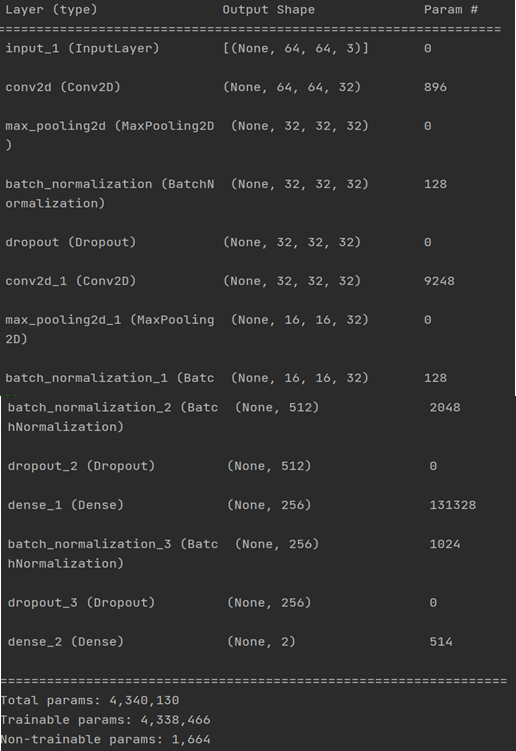

## Split the dataset


In [ ]:

# I split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size=0.20,
                                                    random_state=0)

# When training with Keras's Model.fit(), adding the tf.keras.callback.TensorBoard callback
# ensures that logs are created and stored. Additionally, enable histogram computation
# every epoch with histogram_freq=1 (this is off by default)
# Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# ### Training the model
# As the training data is now ready, I will use it to train the model.

# Fit the model
history = model.fit(np.array(X_train),
                    y_train,
                    batch_size=64,
                    verbose=1,
                    epochs=5,  # Changed to 3 from 50 for testing purposes.
                    validation_split=0.1,
                    shuffle=False
                    #   callbacks=callbacks
                    )

## Accuracy calculation

In [ ]:
# I'll now calculate the accuracy on the test data.

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1] * 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy']) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()
# Save the model
model.save('malaria_cnn.h5')

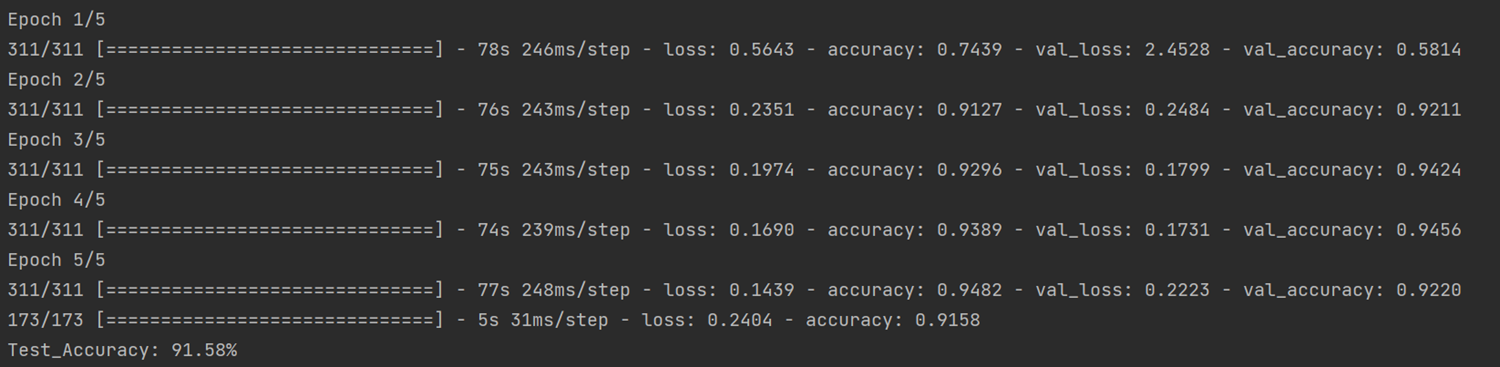

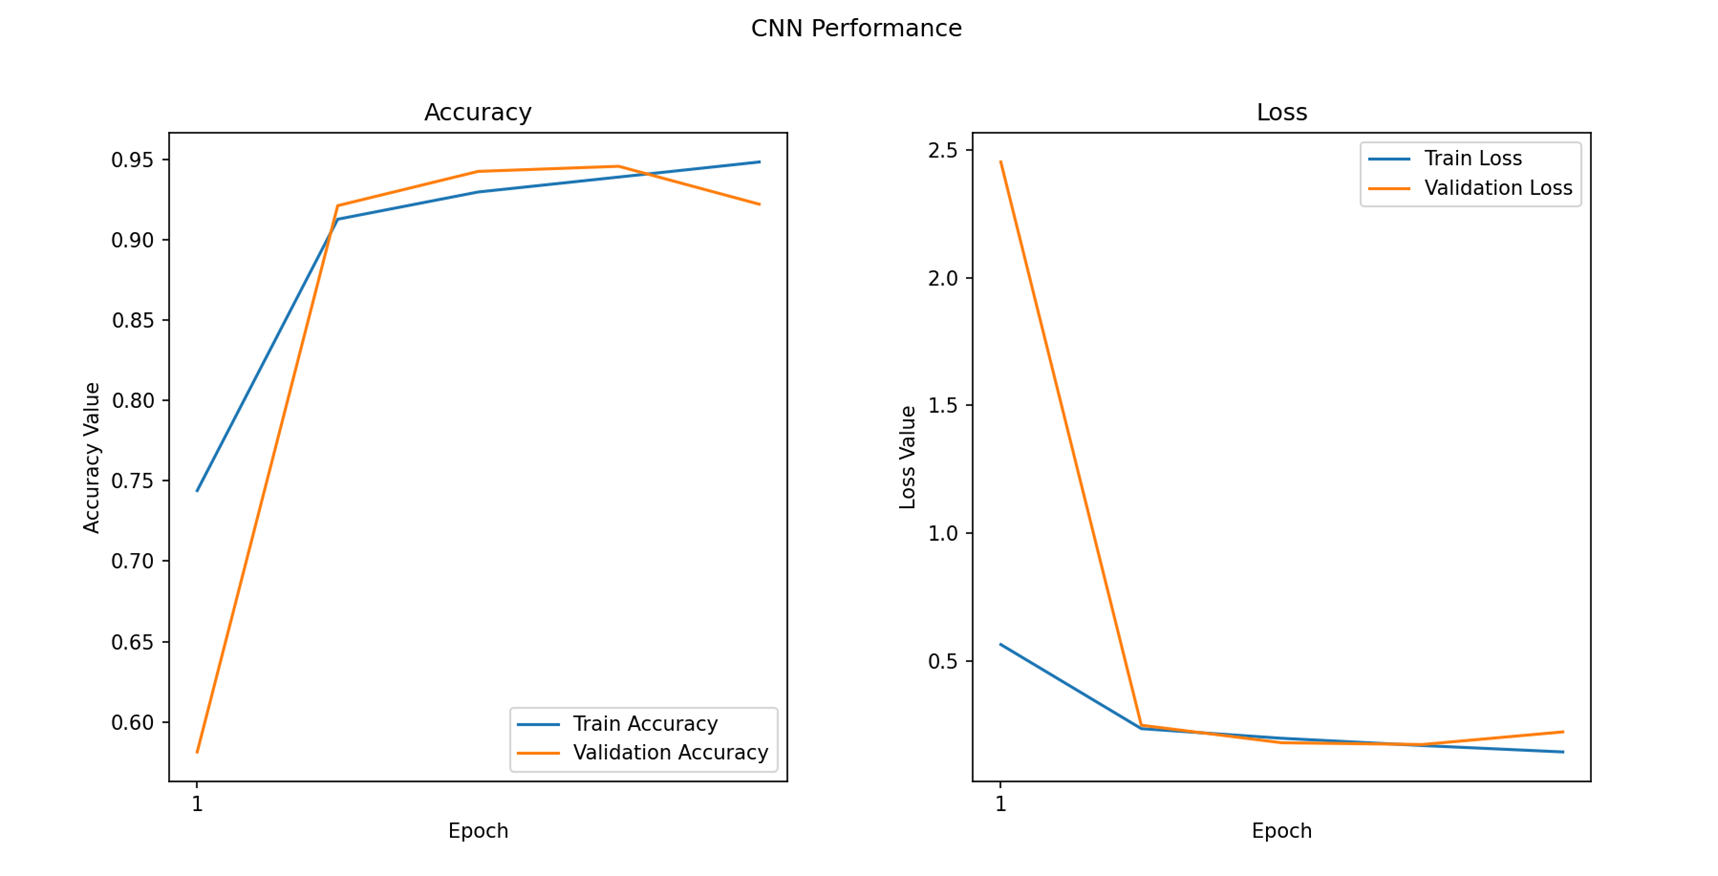

## Another way to define the network: using Sequential model

In [ ]:

# Sequential
# You can create a Sequential model by passing a list of layer instances to the constructor:
"""
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
model = None
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=2))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
"""

